In [2]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.9 MB/s eta 0:00:00


In [1]:
pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 995.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 KB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [35]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import datetime

In [6]:
import collections #Resolvendo incompatibilidade 
collections.Callable = collections.abc.Callable

In [4]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
ee.Authenticate() 

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=n3M04-yl38oUB9aYWwYokhoVzAuQb2GgwG68rvsD_Nc&tc=0ElxrgBwbLsxvjw_26k5qRVYwmjqv2EfybkQiLITh7o&cc=U29cvn5r0HWrI6QDI2-MzeqANFIKEoRq6V2SvnxQi6Q

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh41zHMR4oftZQm6Yrviz2xyPcbRjmo4jNyX5e5qtorGCvsr9ORMQNM

Successfully saved authorization token.


In [7]:
ee.Initialize()

In [8]:
Map = geemap.Map()

In [10]:
ROI_shp = '/content/drive/MyDrive/Scripts/NDVI_script/Bacia_TCC.shp'
ROI = geemap.shp_to_ee(ROI_shp)

In [11]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR") #https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

In [12]:
# Função apara remover nuvens
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])

In [61]:
filtered = s2 \
  .filter(ee.Filter.date('2018-01-01', '2022-10-31')) \
  .filter(ee.Filter.bounds(ROI)) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) \
  .map(maskS2clouds)

In [62]:
# Função para calcular do NDVI e acrescenta banda no conjunto de imagens da composição
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

In [63]:
S2_Ndvi = filtered.map(addNDVI) #Aplicando na imagens para 

S2_composite = S2_Ndvi.median() #Imagem reduzida com a mediana do período

In [64]:
#Parametros de visualização
palette = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']

ndviVis = {'min':0, 'max':0.5, 'palette': palette }

rgbVis = {'min': 0.0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

In [65]:
def clip(image):
   return image.clip(ROI)

In [66]:
ROI_exp = S2_Ndvi.select('ndvi').map(clip)
ROI_exp

In [67]:
#Adicionando as camadas no mapa

#Map.addLayer(S2_Ndvi.select('B4', 'B3', 'B2'), rgbVis, 'RGB')

#Map.addLayer(S2_Ndvi.select('ndvi'), ndviVis, 'NDVI')

Map.addLayer(ROI_exp, ndviVis, 'NDVI_ROI')

#Map.addLayer(ROI, {}, 'ROI')

Map.centerObject(ROI, 10)
Map
# Geemap permite fazer visualizações intermediárias com o menu interativo

Map(bottom=155665.0, center=[-31.62153653218031, -56.18759173447512], controls=(WidgetControl(options=['positi…

In [68]:
###Exportar imagens
#from ee import geometry
#geemap.ee_export_image_collection_to_drive(ROI_exp, folder='NDVI_script', scale=10, maxPixels=69335554760) 

In [69]:
#Função para redução da coleção utilizando a média para a área ROI e associação com a data da imagem

def roi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI, scale=10).get('ndvi')
    return img.set('date', img.date().format()).set('ndvi',mean)

In [70]:
ROI_reduced = ROI_exp.map(roi_mean)
ROI_reduced

In [71]:
# Redução da coleção de imagens em lista para converter em dataframe com data e média do NDVI

S2_Ndvi_list = ROI_reduced.reduceColumns(ee.Reducer.toList(2), ['date','ndvi']).values().get(0)
#S2_Ndvi_list

In [72]:
# Converção em dataframe e ajuste do formato da data

df = pd.DataFrame(S2_Ndvi_list.getInfo(), columns=['date','ndvi'])
df['date'] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y')
df = df.set_index('date')

df.head()

ndvi
date                
05-02-2019  0.698804
20-02-2019  0.682605
20-02-2019  0.687145
02-03-2019  0.683584
02-03-2019  0.677330

df2 = df.groupby(df['Date'])['ndvi'].agg(['mean'])
df2

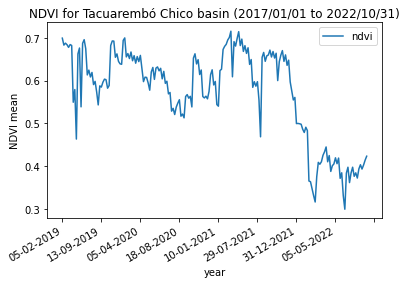

In [73]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

ax = df.plot()

plt.gcf().autofmt_xdate()
plt.xlabel("year")
plt.ylabel("NDVI mean")
plt.title('NDVI for Tacuarembó Chico basin (2017/01/01 to 2022/10/31)')

plt.show()